In [181]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

##### 讀取數據

In [182]:
KKboxTrainMembers = pd.read_csv('KKboxTrainMembers.csv')

In [183]:
KKboxTrainMembers.head()

,msno,is_churn,city,bd,registered_via,register_year,register_month,register_day,Gender_female,Gender_male
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,9.0,2005.0,4.0,6.0,1,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,9.0,2005.0,4.0,7.0,0,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,9.0,2005.0,10.0,16.0,1,0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,9.0,2005.0,11.0,2.0,1,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,9.0,2005.0,12.0,28.0,0,1


In [184]:
print(KKboxTrainMembers.shape)
KKboxTrainMembers.info(memory_usage='deep')

(1738128, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738128 entries, 0 to 1738127
Data columns (total 10 columns):
msno              object
is_churn          int64
city              float64
bd                float64
registered_via    float64
register_year     float64
register_month    float64
register_day      float64
Gender_female     int64
Gender_male       int64
dtypes: float64(6), int64(3), object(1)
memory usage: 286.8 MB


In [185]:
Col = ['city', 'bd', 'registered_via', 'register_month', 'register_day']
for i in Col:
    KKboxTrainMembers[i] = KKboxTrainMembers[i].astype('float32')

* 因為本數據集有數據不平衡的問題，如果直接對數據進行建模的話，會產生模型用於測試不準確的問題，先用隨機森林進行確認是否存在偏倚的現象

### RandomForestClassifier

##### 拆分訓練集與測試集

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
X = KKboxTrainMembers.iloc[:,2:]
y = KKboxTrainMembers.iloc[:,1]

In [188]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=87)

In [189]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype float32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


---

##### 建立隨機森林分類模型

In [190]:
from sklearn.ensemble import RandomForestClassifier

In [191]:
dt = RandomForestClassifier(n_estimators = 40, criterion='entropy', random_state=0) 

##### 訓練

In [192]:
dt.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [193]:
dt.score(X=X_train, y=y_train)

0.9578733760229606

##### 預測

In [194]:
pred = dt.predict(X_test) 

##### 確認

In [195]:
cm = metrics.confusion_matrix(y_test, pred)
cm

array([[471101,   8640],
       [ 38260,   3438]], dtype=int64)

In [196]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred)

In [197]:
print('AUC: %.3f' % auc)

AUC: 0.532


In [198]:
# y_score = dt.predict_proba(X_test)[:,1]

In [199]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred)

##### 繪製ROC

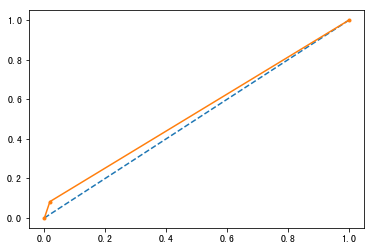

In [200]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

* 結果有很大的偏倚，所以還是要針對數據不平衡的問題進行解決

##### 使用SMOTE處理數據不平衡問題

In [201]:
from imblearn.over_sampling import SMOTE

In [202]:
over_samples = SMOTE(random_state=87)

In [203]:
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, y_train) 

In [204]:
print(y_train.value_counts()/len(y_train)) 

0    0.919943
1    0.080057
Name: is_churn, dtype: float64


In [205]:
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

1    0.5
0    0.5
dtype: float64


##### 建立第二個隨機森林分類模型

In [206]:
dt2 = RandomForestClassifier(n_estimators = 20, criterion='entropy', random_state=0) 

##### 訓練

In [207]:
dt2.fit(over_samples_X,over_samples_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [208]:
dt2.score(X=over_samples_X, y=over_samples_y)

0.8962841423624388

##### 預測

In [209]:
pred2= dt2.predict(np.array(X_test))

##### 確認

In [210]:
cm2 = metrics.confusion_matrix(y_test, pred2)
cm2

array([[440623,  39118],
       [ 31642,  10056]], dtype=int64)

In [211]:
auc2 = roc_auc_score(y_test, pred2)

In [212]:
print('AUC: %.3f' % auc2)

AUC: 0.580


In [213]:
fpr, tpr, thresholds = roc_curve(y_test, pred2)

##### 繪製ROC

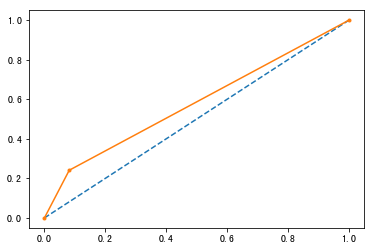

In [214]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

## RandomForestRegressor

In [215]:
from sklearn.ensemble import RandomForestRegressor

In [216]:
rfg = RandomForestRegressor(n_estimators=40)

##### 訓練

In [217]:
rfg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [218]:
rfg.score(X_train, y_train)

0.5208104944953121

##### 預測

In [219]:
rfg_pred = rfg.predict(X_test)

In [220]:
auc_rfg = roc_auc_score(y_test, rfg_pred)

In [221]:
print('AUC: %.3f' % auc_rfg)

AUC: 0.707


In [222]:
fpr_rfg, tpr_rfg, thresholds = roc_curve(y_test, rfg_pred)

##### 繪製ROC

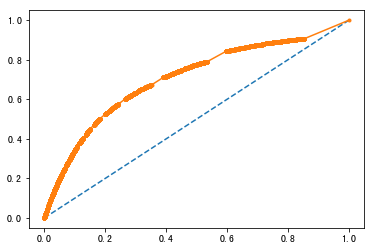

In [223]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rfg, tpr_rfg, marker='.')
# show the plot
plt.show()

##### 使用SMOTE處理數據不平衡後

##### 訓練

In [224]:
rfg2 = RandomForestRegressor(n_estimators=40)

In [225]:
rfg2.fit(over_samples_X,over_samples_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [226]:
rfg2.score(X=over_samples_X, y=over_samples_y)

0.7159318389542126

##### 預測

In [227]:
rfg_pred2 = rfg2.predict(X_test)

In [228]:
auc_rfg2 = roc_auc_score(y_test, rfg_pred2)

In [229]:
print('AUC: %.3f' % auc_rfg2)

AUC: 0.616


In [230]:
fpr_rfg2, tpr_rfg2, thresholds_rfg2 = roc_curve(y_test, rfg_pred2)

##### 繪製ROC

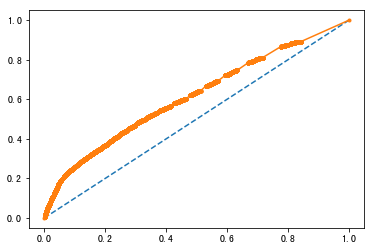

In [231]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rfg2, tpr_rfg2, marker='.')
# show the plot
plt.show()